In [1]:
from pylab import *
import numpy as np

# Homework 2: An HI model of the MW

This week we'll be constructing models for the properties of HI in the Galaxy using the results of HI 21 cm surveys. 

## I. HI galactic structure
We'll be taking a spectrum along a specific line of sight defined by the galactocentric longitude $l$ and trying to calculate the physical neutral hydrogen number density $n_H$. 

The spectra for each $l$ are in their own `.txt` file, with columns for the radial velocity $v_{lsr}$ in km/s and brightness $T_b$ in K.
In order to spatially map this emission, we're going to calculate the kinematic distances for a sample radial velocity assuming a flat Galactic rotation curve. 
The expression for the radial velocity is a function of the galactic rotation curve $v_0$ scaled to the location of the solar circle $r_0$ and the galactice longitude and latitude, $l$ and $b$. We're going to restrict this to the midplane, taking spectra only for $b=0$. For a flat rotation curve, the expression becomes:

$v_{lsr} = v_0\sin(l)(r_0/r - 1)$

Using this relationship, we can calculate the galactocentric radius, $r$ from the measured radial velocities $v_{lsr}$. The law of cosines then gives a solution for the distance from the Sun as:

$s = r_0 \cos(l) \pm \sqrt(r^2 - r_0^2 \sin^2 (l))$

This presents two solutions for the line of sight distance when $r < r_0$, an effect known as the kinematic distance anomaly (KDA).  
<img src = "kda.png" width=20% height=20%>
Figure is Figure 1 from [Roman-Duval et al., 2009](https://ui.adsabs.harvard.edu/abs/2009ApJ...699.1153R/abstract). See ref for more details.

To make our lives easier, here, we are going to exclude our analysis to everything outside of the solar circle, such that $r/r_0 > 1$, so that there is only one solution for the source distance $s$. Since the galactic rotation curve is still a bit wiggly, departing from the solar circle value by more than 10 km/s for R > 30 kpc, (see Figure 2 in Kalberla & Kerp 2009), let's also prescribe the limit to be $r/r_0 < 30/r_0$. 
For angles $l < 180$, the radial los velocity component of galactic rotation $v_0 \sin(l) > 0$, while for $l> 180$, $v_0 sin(l) < 0$ -- looking toward the current vs. against it. 

For our purposes we will adopt $r_0 = 8.5 \mathrm{kpc}$ and $v_0 = 220 \mathrm{km /s }$

### Part a
Derive the threshhold of $v_{lsr}$ for:  
a. $r/r0 = 1$  
b. $r/r0 = 30/r_0$  

Use the derived threshhold to define a function below that takes an rmin and rmax and returns a tuple of the corresponding vmin and vmax in terms of $v_0 \sin(l)$

In [2]:
def get_vlim(rmin=8.5,rmax=30.,r0=8.5):
    v_lim_1 = (r0/rmin-1)
    v_lim_2 = (r0/rmax-1)

    return (v_lim_1,v_lim_2)

Go to the survey data website: https://www.astro.uni-bonn.de/hisurvey/AllSky_profiles/index.php 
Input a galactic longitude between 30 and 330 degrees (whatever you want!) and click search. You will see a spectrum and a link that says:
`Download this data as an ascii file`. Click the link and save the file to your working directory.

Below I've included a class that reads in this type of spectrum file and a galactic longitude and performs basic calculations.
The function `clean_spectrum` will use the function you just defined to bin the spectrum within the resulting velocity threshholds in order to limit the analysis to those between the defined galactocentric radii. Read over the methods and get acquainted with the properties of the class and make sure you understand how the function you wrote is going to be used.

In [3]:
from scipy import stats
pctocm = 3.086e18
kpctocm = pctocm*1000

class spec_calc:
    def __init__(self,l,filename,rmin=None,rmax=None):
        """ method initializes with galactic longitude l in degrees and filename of spectrum file to read.
        As part of initialization, this will:
        1. read in the spectrum 
        2. clean the spectrum (bin the spectrum in the range vmin and vmax with bins of size dv)
        3. calculate the galactocentric radius of the velocities
        4. calculate the distances from the galactocentric radius"""
        self.l = l
        if rmin is None:
            self.rmin = 8.5
        else:
            self.rmin = rmin
        if rmax is None:
            self.rmax = 30.0
        else:
            self.rmax = rmax
        self.data = self.read_spectrum(filename)
        v_bins, self.T_b = self.clean_spectrum()
        self.vlsr = (v_bins[1:]+ v_bins[:-1])*0.5
        self.dv = np.diff(v_bins)
        r_bins = self.r_gc(v_bins) #bin edges corresponding to the velocity bins in terms of r_gc
        s_bins = self.dist(r_bins) #bin edges corresponding to the velocity bins in terms of los distance
        self.ds = np.abs(np.diff(s_bins)) #width of each bin in los distance
        self.r_ =(r_bins[1:]+r_bins[:-1])*0.5 #galactocentric radii coordinates
        self.s_ = (s_bins[1:]+s_bins[:-1])*0.5 #line of sight distance

    def read_spectrum(self,filename):
        """ reads in a file with spectral information and returns a list of vlsr [km/s] and Tb [K]"""
        data = np.loadtxt(filename,comments="%")
        vr = data[:,0]
        Tb = data[:,1]
        return (vr, Tb)

    def clean_spectrum(self,dv=2,v0=220.):
        """ returns a binned spectrum with velocity bins of width dv within some threshold vmin and vmax given by the get_lim() function"""
        l = np.radians(self.l)
        vr, Tb = self.data
        v_lim_1, v_lim_2 = get_vlim(rmin=self.rmin,rmax=self.rmax)
        v_lim_1 *= v0*np.sin(l)
        v_lim_2 *= v0*np.sin(l)
        v_min = min(v_lim_1,v_lim_2)
        v_max = max(v_lim_1,v_lim_2)
        bins_e = np.arange(v_min,v_max,dv) #bin_edges
        bins = (bins_e[1:]+bins_e[:-1])*0.5 #bin_centers
        Tb_binned = stats.binned_statistic(vr,Tb,bins=bins_e)[0]
        return bins_e, Tb_binned

    def r_gc(self,vr,r0=8.5,v0=220.):
        """ calculates the galactocentric radius assuming a flat rotation curve"""
        l = np.radians(self.l)
        v_lim = v0*np.sin(l)
        return r0*np.sin(l)*v0/(vr+v_lim)

    def dist(self,r_,r0=8.5):
        """ calculates the kinematic distance of a source based on the galactocentric R and l"""
        l = np.radians(self.l)
        return r0*np.cos(l) + np.sqrt( r_*r_ - r0*r0*np.sin(l)*np.sin(l))




The following script will plot the raw data vs the cleaned spectrum and the converted galactocentric distances for the brightness temperatures. Put in the path to your file for `file_in` and the longitude you chose for `l_in`. If your function works as it should, the resulting $R_{gc}$ should be between 8.5 kpc and 30 kpc.

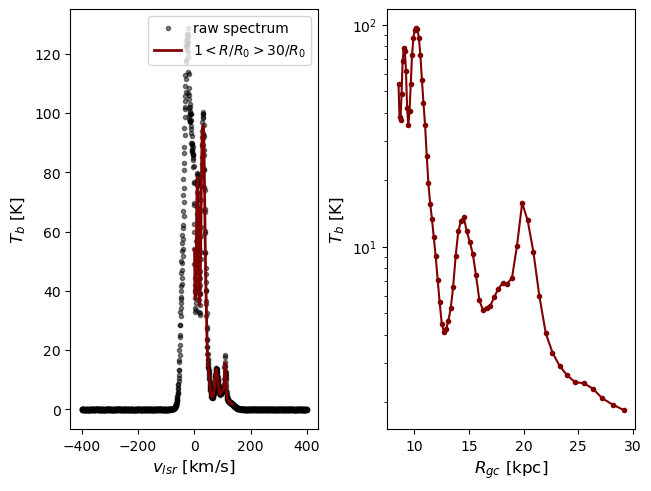

In [4]:
file_in= 'spectrum.txt'
l_in = 300
spec = spec_calc(filename=file_in,l=l_in)

f,ax = subplots(1,2,constrained_layout=True,dpi=100)
ax[0].plot(*spec.data,'k.',alpha=0.5,label='raw spectrum')
ax[0].plot(spec.vlsr, spec.T_b,color='maroon',lw=2,label=r'$1 < R/R_0 > 30/R_0$')
ax[0].set_xlabel(r'$v_{lsr}$ [km/s]',fontsize=12)
ax[0].set_ylabel(r'$T_b$ [K]',fontsize=12)
ax[0].legend(loc=1)

ax[1].plot(spec.r_, spec.T_b,'.-',color='maroon')
ax[1].set_xlabel(r'$R_{gc}$ [kpc]',fontsize=12)
ax[1].set_ylabel(r'$T_b$ [K]',fontsize=12)
ax[1].set_yscale('log')

### Part b
Now we have a mapping of each velocity bin to a distance, we want to get an understanding of what the column is at each distance. 
Of course, we could sum over the entire spectrum and get the total column density along the line of sight, but using our rotation curve model, the kinematic distances we've derived mean that we can use the velocities to somewhat separate out the column into contributions from a set of distances. Basically, we're assuming that each $dv$ of the spectrum comes from a unique distance, and thus maps onto a column density measurement summed over $ds$ along the line of the sight. 

Write a function that calculates the column density of hydrogen for a bin of width $dv$ at a temperature $T_b$. 

Hint:
Equations 13.8 and 13.10 in the [Radio Astronomy manual](https://www.asu.cas.cz/~barta/ARC-doc/ToolsOfRadioAstronomy.pdf) are a good place to start. Assume no background temperature and recall that for HI, we're going to assume optically thin emission such that $\tau \ll 1$. 

Calculate the column density for each velocity bin and plot with respect to the line of sight distance.

Text(0, 0.5, '$N_H \\ \\mathrm{[cm^{-2}]}$')

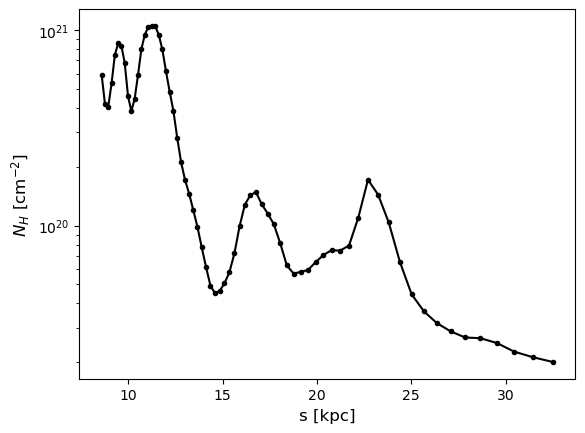

In [71]:

def NH_bin(Tb, dv):
    v = spec.vlsr
    
    N_H = 1.8223*3e18 * Tb*dv
    return N_H


NH_bins = NH_bin(spec.T_b,spec.dv)
f,ax=subplots(1,dpi=100)
ax.semilogy(spec.s_, NH_bins,'k.-')
ax.set_xlabel('s [kpc]',fontsize=12)
ax.set_ylabel(r'$N_H \ \mathrm{[cm^{-2}]}$',fontsize=12)

### Part c
Using this model, each measurement comes from a single $ds$ along the line of sight, so we can approximate the volume density of H atoms as a function of distance as $n_H \sim N_H / ds$.
Use the quantities to calculate $n_H$ for each point and plot with respect to the galactocentric radius $R_{gc}$. 

As a comparison, on the same plot, plot the average midplane number density of neutral hydrogen from Kalberla and Kerp (Section 3.1.3)

How does your derived number density along your single line of sight compare to the smoothed profile of the galactic average?


Text(0, 0.5, '$n_H \\ \\mathrm{[cm^{-3}]}$')

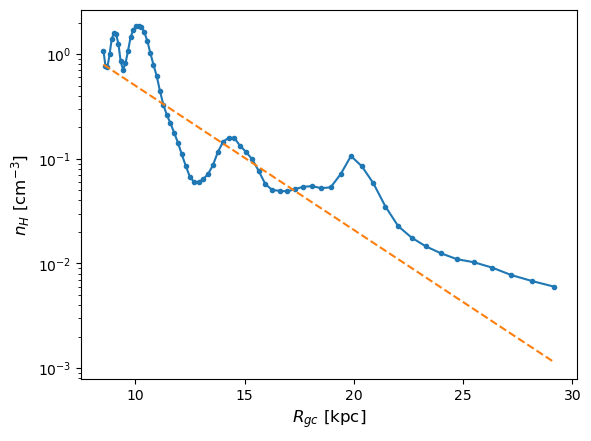

In [72]:

nh_bins = NH_bins/spec.ds/kpctocm


def n_kk(rgc):
    return 0.9*np.e**(-(rgc-8.15)/3.15)


f,ax = subplots(1,dpi=100)
ax.semilogy(spec.r_,nh_bins,'.-')
ax.semilogy(spec.r_, n_kk(spec.r_),'--')
ax.set_xlabel(r'$R_{gc}$ [kpc]',fontsize=12)
ax.set_ylabel(r'$n_H \ \mathrm{[cm^{-3}]}$',fontsize=12)


### Part d: *Menu* points (Optional)
For a menu point for this week, write a script to perform the above analysis for multiple spectra taken along different lines of sight $l$. Make the plot for Part c, with the nH(r) plotted for every $l$. How does the average of those lines compare to the galactic average?

For these purposes, you might find it useful to download spectrum files using python, below is a code that will request a file at a specific galactic longitude from the survey. 

In [7]:
import requests

long = '100.00'
url = "https://www.astro.uni-bonn.de/hisurvey/AllSky_profiles/download.php?ral="+long+"&decb=0.00&csys=0&beam=0.200"

s = requests.Session()
response = s.get(url)

with open('spec'+long+'.txt', 'wb') as file:
    file.write(response.content)

## II. Equilibrum Temperature of the ISM




Let's build an ISM thermal model.
We'll need sources of heating and cooling.
We're going to pull from some models in [Wolfire,2003](https://ui.adsabs.harvard.edu/abs/2003ApJ...587..278W/abstract)

We're going to use:
1. CII cooling (Eq. C1 in Wolfire, 2003)
2. OI cooling (Eq., C3 in Wolfire 2003)
3. Lyman-alpha cooling, given by:

$n^2 \Lambda_{Ly\alpha} = 2.0\times 10^{-21}\left({n_e/n_H\over 10^{-4}}\right)^2 n_H^2\left({8000\over T}\right)^{1/2} \,e^{-1.2\times 10^5/T} {\rm erg/s/cm^3}$ 

For heating we will include:
1. Photoelectric grain heating (Eq. C5 in Wolfire 2003)
2. Cosmic-ray heating, given by:
$ \begin{align} n \Gamma_{CR} &= n_H \zeta_H \langle E \rangle \\ &= 5.4\times 10^{-28}\left({n_H\over 1\,{\rm cm}^{-3}}\right) \left({\zeta_H\over 10^{-16}\,{\rm s}^{-1}}\right) \left({\langle E\rangle\over 3.4\,{\rm eV}}\right) {\rm erg/s/cm^3}. \end{align} $

We'll also need the electron density, for which you can use Eq. C15 from Wolfire, 2003. 

Assume a cosmic ray ionization rate of $\zeta_H = 1.3 \times 10^{-16} /s $ and a PAH fraction of 0.5. 
For the equations from Wolfire, 2003, assume values at the solar circle. (i.e. every term with a prime (for ex. $G_0^\prime$) is set to 1.)







### Part a

Write a function for each heating and cooling term in terms of $T$ and $n$. Remember that conventions can change between papers, so pay attention to the units.

Make a plot of the heating and cooling contributions as a function of temperature with one panel at $n = 1 \mathrm{cm^{-3}}$.

Write a caption for the plot describing the dominant sources of heating and cooling at different temperatures.

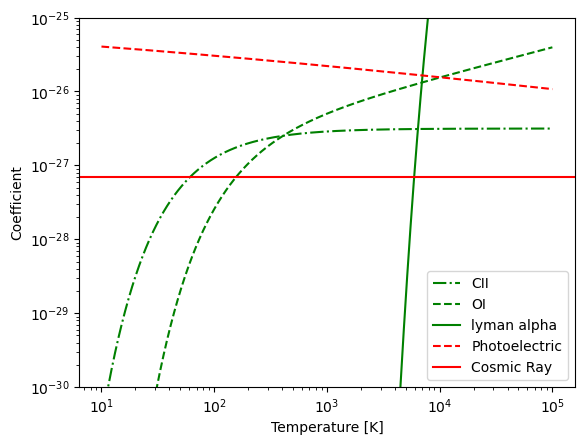

In [8]:

T =np.linspace(10,100000,1000000)

### Cooling
def CII_cooling(T,n=1):
    T2= T/100
    return (3.15e-27*np.exp(-0.922/(T2)))*n**2
def OI_cooling(T,n=1):
    T2= T/100
    return (2.5e-27*(T2)**0.4 * np.exp(-2.28/(T2)))*n**2
def lyman_alpha(T,n=1):
    T2= T/100
    n_e = 2.4e-3 *(T2)**(1/4)*0.5**-1
    return 2.0e-21*((n_e/n)/10e-4)**2 * n**2 * (8000/T)**.5*np.exp(-1.2e5/T)
### Heating
def photoelectric(T,n=1):
    T2= T/100
    n_e = 2.4e-3 *(T2)**(1/4)*0.5**-1
    return (1.1e-25*n)/(1+3.2e-2*((T2**0.5)/(n_e*0.5))**0.73)
def cosmic_ray(T,n=1):
    kb=1.38e-23
    avgE= .5*kb*T*6.242e+18
    return 5.4e-28*n*1.3*(3.4/3.4)

f,ax = subplots(1,dpi=100)
ax.semilogy(T,CII_cooling(T),color='g',ls='-.', label='CII')
ax.semilogy(T,OI_cooling(T),color='g',ls='--', label='OI')
ax.semilogy(T,lyman_alpha(T),color='g', label='lyman alpha')
ax.semilogy(T,photoelectric(T),color='r',ls='--', label='Photoelectric')
ax.axhline(cosmic_ray(T),color='r',label='Cosmic Ray')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-30,1e-25)
ax.set_ylabel("Coefficient")
ax.set_xlabel("Temperature [K]")

ax.legend()


### Part b

Write a function that calculates the total (Heating - Cooling), as a function of $n$ and $T$. 
For a range of ISM number densities between 0.01 and 100, use this function and a routine in `scipy.optimize` to numerically solve for the equilibrium temperature at each n. 

According to the cooling and heating rates we used here, what is equlibrium temperature and pressure around the canonical WNM/CNM values? 

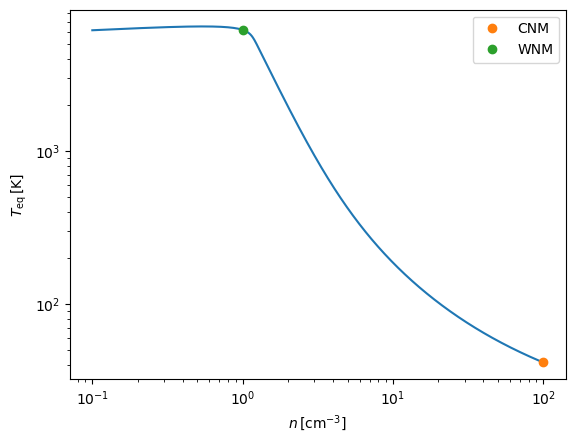

In [76]:
from scipy import optimize
n_list= np.linspace(0.1,100,10000)
T =np.linspace(10,100000,10000)
CNM = 1e8 / 1e6 
WNM = 1e6 / 1e6 
min_temp_list =[]
def total(T,n):
        heating = cosmic_ray(T,n) + photoelectric(T,n)
        cooling = CII_cooling(T,n) + OI_cooling(T,n) + lyman_alpha(T,n)
        return np.abs(heating - cooling)
# n=100
# results=optimize.newton(total,x0=(100,), args =(n,))
# print(results)
for n in n_list:
    T_guess = T[argmin(total(T, n))] 
    results=optimize.newton(total,T_guess, args =(n,))
    min_temp_list.append(results)

T_guess_CNM = T[argmin(total(T, CNM))] 
T_CNM=optimize.newton(total,T_guess_CNM, args =(CNM,))
T_guess_WNM = T[argmin(total(T, WNM))] 
T_WNM=optimize.newton(total,T_guess_WNM, args =(WNM,))

plot(n_list,min_temp_list)
plot(CNM,T_CNM,'o', label="CNM")
plot(WNM,T_WNM,'o', label="WNM")
legend()
xlabel(r'$n\,[{\rm cm}^{-3}]$')
ylabel(r'$T_{\rm eq}\,[{\rm K}]$')
xscale('log')
yscale('log')




## ANSWERS:
The equilibrium temp for CNM is 41.45 K and the equlibrium pressure is 4145.23 ${\rm cm}^{-3} {\rm K}$.
The equilibrium temp for WNM is 6230.56 K and the equlibrium pressure is 6230.56 ${\rm cm}^{-3} {\rm K}$.

### Part c
Plot the equilibrium pressure vs. the number density and compare to the FGH curve solution we discussed in class. 

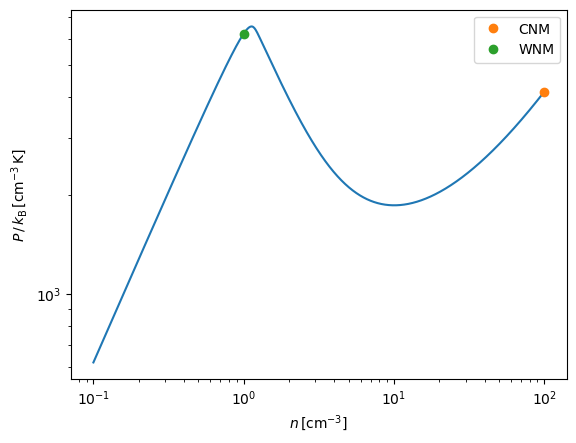

In [65]:
plot(n_list, n_list*min_temp_list)
plot(CNM,CNM*T_CNM,'o', label="CNM")
plot(WNM,WNM*T_WNM,'o', label="WNM")
legend()
xlabel(r'$n\,[{\rm cm}^{-3}]$')
ylabel(r'$P\,/\,k_{\rm B}\,[{\rm cm}^{-3}\,{\rm K}]$')
xscale('log')
yscale('log')

## ANSWERS:
When comparing to the FGH curve from class, the calculated CNM value lines up well with where it would appear on the FGH curve. However, the calculated WNM value appears much higher on the curve than expected from the FGH curve.